![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

In [4]:
len(y_train), len(y_test)

(60000, 10000)

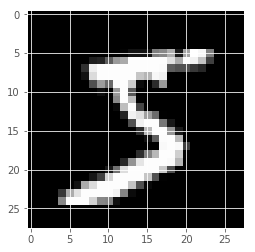

tensor(5)


In [5]:
plt.imshow(X_train[0, :, :], cmap='gray')
plt.show()
print(y_train[0])

In [6]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [7]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

lenet5 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    Flatten(),
    torch.nn.Linear(5 * 5 * 16, 120),
    torch.nn.Tanh(),
    torch.nn.Linear(120, 84),
    torch.nn.Tanh(),
    torch.nn.Linear(84, 10)
)

lenet5 = lenet5.to(device)

In [10]:
from IPython.core.display import clear_output


def train_loop(model, optimizer, loss, X_train, X_test, y_train, y_test, batch_size=500, n_epoch=10):
    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(n_epoch):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = model.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        test_preds = model.forward(X_test)
        # почему не стоит писать test_loss_history.append(loss(test_preds, y_test)):
        # в объекте, который возвращает loss, хранится не просто число, а весь граф, который помогает сделать backward
        # этот объект хранится на device (вероятно, GPU) и не чистится, поскольку каждый раз добавляем его в лист 
        # по этой причине, если писать просто test_loss_history.append(loss(test_preds, y_test)), 
        # можем получить MemoryError
        # чтобы этого не происходило: берем поле .data у объекта, который возвращает loss(), и переносим его на cpu
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
        
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.plot(test_accuracy_history)
        plt.subplot(122)
        plt.plot(test_loss_history)
        plt.show()

    return test_accuracy_history, test_loss_history

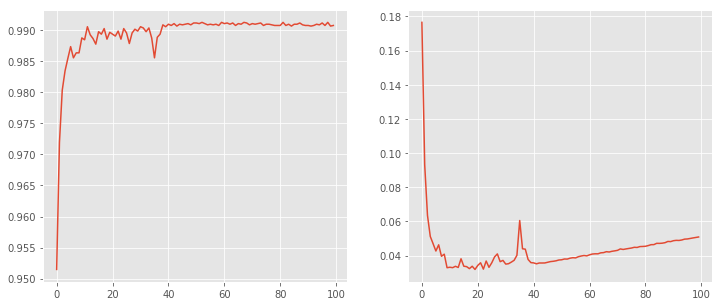

In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
lenet_accuracy, lenet_loss = train_loop(lenet5, optimizer, loss,
                                        X_train, X_test, y_train, y_test, n_epoch=100)

In [12]:
modified_net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1),
    torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1),
    torch.nn.ELU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0),
    torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0),
    torch.nn.ELU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),
    Flatten(),
    torch.nn.Linear(5 * 5 * 16, 120),
    torch.nn.ELU(),
    torch.nn.Linear(120, 84),
    torch.nn.ELU(),
    torch.nn.Linear(84, 10)
)
modified_net = modified_net.to(device)

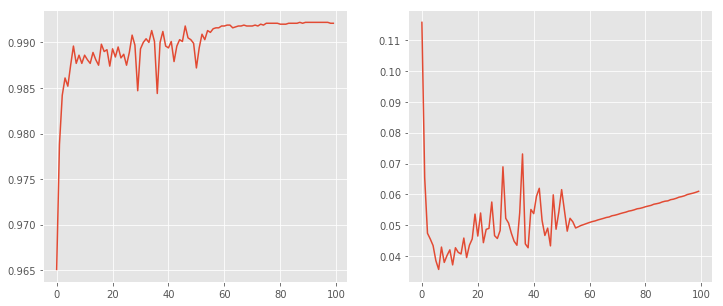

In [13]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modified_net.parameters(), lr=5.0e-4)
modified_net_accuracy, modified_net_loss = train_loop(modified_net, optimizer, loss,
                                                      X_train, X_test, y_train, y_test, n_epoch=100)

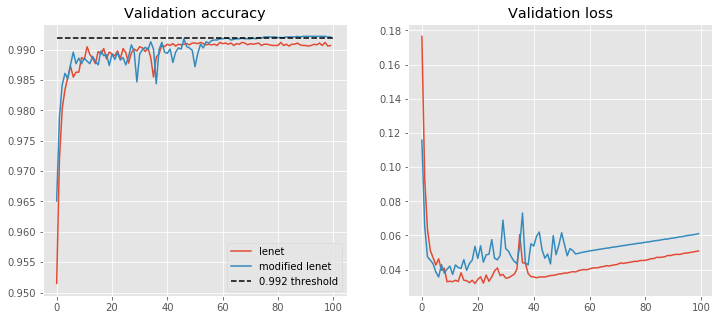

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title('Validation accuracy')
plt.plot(lenet_accuracy, label='lenet')
plt.plot(modified_net_accuracy, label='modified lenet')
plt.plot([0, len(lenet_accuracy)], [0.992, 0.992], 'k--', label='0.992 threshold')
plt.legend()
plt.subplot(122)
plt.title('Validation loss')
plt.plot(lenet_loss)
plt.plot(modified_net_loss)
plt.show()